## Data Preprocessing

In [ ]:
import zipfile

path_to_zip_file = "data/PKlot_duzy.zip"
directory_to_extract_to = "data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

### Merge all folders into one

In [24]:
import os
import shutil

source_folders = [
    "data/PKLot/PKLot/PKLot/PUCPR/Cloudy",
    "data/PKLot/PKLot/PKLot/PUCPR/Sunny",
    "data/PKLot/PKLot/PKLot/PUCPR/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR04/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR04/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR04/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR05/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR05/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR05/Rainy"
]

destination_folder = "data/total-content"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate through source folders and merge contents
for source_folder in source_folders:
    for root, _, files in os.walk(source_folder):
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_folder, file)
            shutil.copy(source_file_path, destination_file_path)

print("Contents merged successfully.")

Contents merged successfully.


### Modify labels

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

input_folder = "data/total-content"
output_folder = "data/labels-xml"

image_width = 1280
image_height = 720

class_mapping = {"1": 1, "0": 0}

# df = pd.DataFrame(columns=['Classidx', 'x_center', 'y_center', 'width', 'height'])

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

xml_files = [f for f in os.listdir(input_folder) if f.endswith(".xml")]
for xml_file in xml_files:
    xml_path = os.path.join(input_folder, xml_file)
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    txt_filename = os.path.splitext(xml_file)[0] + ".txt"
    txt_path = os.path.join(output_folder, txt_filename)

    with open(txt_path, "w") as txt_file:
        for space in root.findall("space"):
            occupied = space.get("occupied")
            class_index = class_mapping.get(occupied, -1)
            
            if class_index == -1:
                continue
            
            rotated_rect = space.find("rotatedRect")
            center = rotated_rect.find("center")
            size = rotated_rect.find("size")
            
            center_x = float(center.get("x"))
            center_y = float(center.get("y"))
            width = float(size.get("w"))
            height = float(size.get("h"))
            
            x_center = center_x / image_width
            y_center = center_y / image_height
            w = width / image_width
            h = height / image_height
            
            txt_file.write(f"{class_index} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
            # df_new_row = pd.DataFrame({ 'Classidx':[class_index], 'x_center':[x_center], 'y_center':[y_center], 'width':[w], 'height':[h] })
            # df = pd.concat([df, df_new_row])
    
    new_xml_path = os.path.join(output_folder, xml_file)
    os.rename(xml_path, new_xml_path)

print("Annotations generated and XML files moved.")

In [11]:
# Move the txt files from the xml folder to the total-content folder

source_folder = "data/labels-xml"
destination_folder = "data/total-content"

txt_files = [f for f in os.listdir(source_folder) if f.endswith(".txt")]

for txt_file in txt_files:
    source_path = os.path.join(source_folder, txt_file)
    destination_path = os.path.join(destination_folder, txt_file)
    shutil.move(source_path, destination_path)

print("TXT files moved to data/total-content folder.")

TXT files moved to data/total-content folder.


### Train - Test - Val folders split

In [12]:
import random
import os

# remove the image that has no corresponding txt file

file_path = "data/total-content/2012-11-06_18_48_46.jpg"
try:
    os.remove(file_path)
    print(f"File '{file_path}' has been removed successfully.")
except OSError as e:
    print(f"Error removing the file '{file_path}': {e}")


source_folder = "data/total-content"
train_folder = "data/train"
test_folder = "data/test"
val_folder = "data/val"

train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

for folder in [train_folder, test_folder, val_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

all_files = os.listdir(source_folder)
image_files = [f for f in all_files if f.endswith(".jpg")]

# Calculate the number of samples for each split
num_samples = len(image_files)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

random.shuffle(image_files)

train_files = image_files[:num_train]
test_files = image_files[num_train:num_train + num_test]
val_files = image_files[num_train + num_test:]

# Move corresponding txt files along with images
for folder, files in [(train_folder, train_files), (test_folder, test_files), (val_folder, val_files)]:
    for file in files:
        # Move image file
        source_image_path = os.path.join(source_folder, file)
        destination_image_path = os.path.join(folder, file)
        shutil.move(source_image_path, destination_image_path)
        
        # Move corresponding txt file
        txt_file = os.path.splitext(file)[0] + ".txt"
        source_txt_path = os.path.join(source_folder, txt_file)
        destination_txt_path = os.path.join(folder, txt_file)
        shutil.move(source_txt_path, destination_txt_path)

print("Data split into train, test, and val sets.")

Error removing the file 'data/total-content/2012-11-06_18_48_46.jpg': [WinError 2] Nie można odnaleźć określonego pliku: 'data/total-content/2012-11-06_18_48_46.jpg'
Data split into train, test, and val sets.


In [13]:
# Organize the datasets into the following structure:
# data
# ├── train
# │   ├── images
# │   └── labels
# ├── val
# │   ├── images
# │   └── labels
# └── test
#     ├── images
#     └── labels


datasets = ['train', 'val', 'test']
source_folder = 'data'

for dataset in datasets:
	dataset_folder = os.path.join(source_folder, dataset)
	
	# Create "images" and "labels" folders
	images_folder = os.path.join(dataset_folder, "images")
	labels_folder = os.path.join(dataset_folder, "labels")
	os.makedirs(images_folder, exist_ok=True)
	os.makedirs(labels_folder, exist_ok=True)
	
	# Organize image and label files
	for file in os.listdir(dataset_folder):
		if file.endswith(".jpg"):
			image_path = os.path.join(dataset_folder, file)
			image_destination = os.path.join(images_folder, file)
			shutil.move(image_path, image_destination)
		elif file.endswith(".txt"):
			label_path = os.path.join(dataset_folder, file)
			label_destination = os.path.join(labels_folder, file)
			shutil.move(label_path, label_destination)

print("Datasets organized successfully.")

Datasets organized successfully.


## Model Loading, Fine Tuning and Evaluation

In [21]:
from ultralytics import YOLO

model = YOLO("result/best.pt")

In [ ]:
# Fine tuning

model.train(data="data/data.yaml", epochs=2)

## Prediction on test set

In [28]:
from PIL import Image
import random
import os

test_images_directory = "./data/test/images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

random_image_path = "data\\test\\images\\2012-09-11_15_27_08.jpg"

results = model.predict(random_image_path)

result = results[0]

print(len(result.boxes))

image 1/1 c:\Users\YogaX1G2\Desktop\TWM\projekt\data\test\images\2012-09-11_15_27_08.jpg: 384x640 32 emptys, 72 occupieds, 435.0ms
Speed: 4.0ms preprocess, 435.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
104


In [ ]:
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))

In [ ]:
# Original image

Image.open(random_image_path)

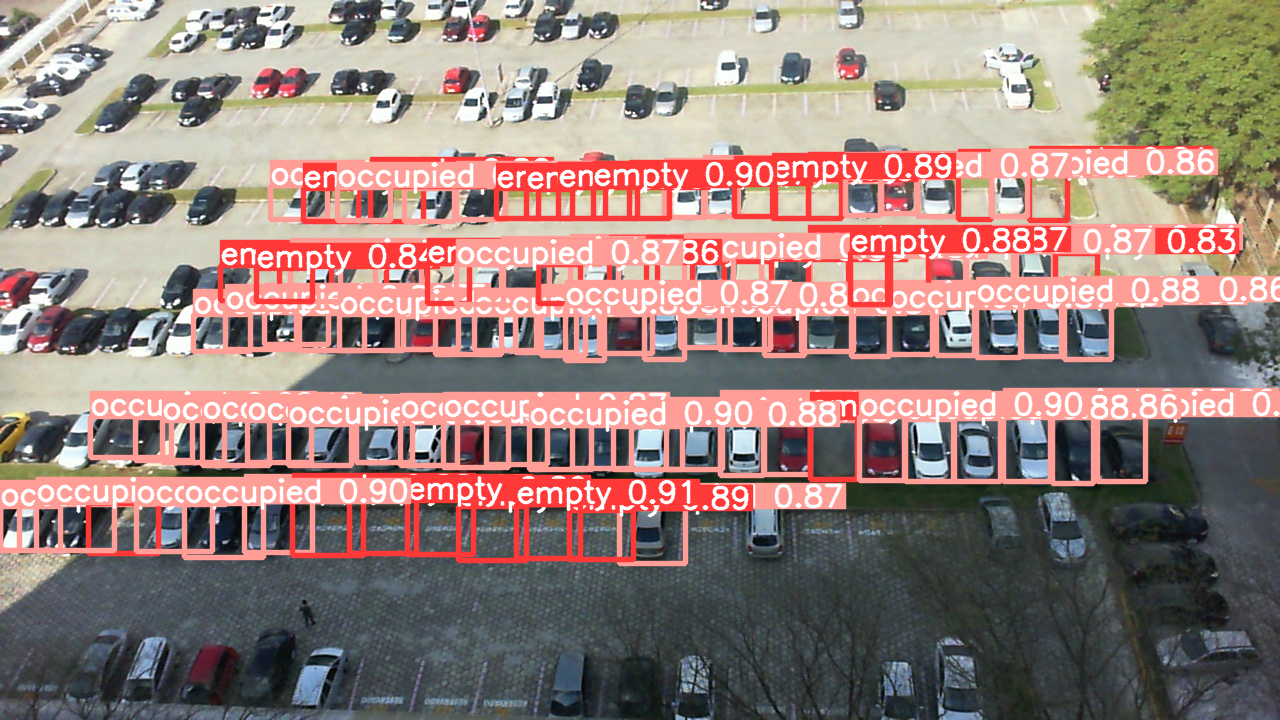

In [29]:
# Image with the result of the model

Image.fromarray(result.plot()[:,:,::-1])

In [ ]:
import os
import json
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from ultralytics import YOLO
import cv2

# Initialize the YOLO model
model = YOLO("result/best.pt")

# Paths to test images and annotations
test_images_dir = "data/test/images"
test_annotations_dir = "data/test/labels"

# List all test images
test_image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(".jpg")]

# Function to create the ground truth and prediction JSON files in COCO format
def create_coco_format_files():
    coco_gt = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "occupied"}, {"id": 0, "name": "free"}]
    }
    coco_pred = []

    annotation_id = 1
    image_id = 1

    for image_file in test_image_files:
        image_path = os.path.join(test_images_dir, image_file)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(test_annotations_dir, label_file)

        if not os.path.exists(label_path):
            continue
        
        # Read image dimensions
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        coco_gt["images"].append({
            "file_name": image_file,
            "id": image_id,
            "width": width,
            "height": height
        })

        with open(label_path, "r") as f:
            lines = f.readlines()

        # Create ground truth annotations
        for line in lines:
            parts = line.strip().split()
            class_idx = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:])
            x_min = int((x_center - w / 2) * width)
            y_min = int((y_center - h / 2) * height)
            bbox_width = int(w * width)
            bbox_height = int(h * height)

            coco_gt["annotations"].append({
                "image_id": image_id,
                "category_id": class_idx,
                "bbox": [x_min, y_min, bbox_width, bbox_height],
                "area": bbox_width * bbox_height,
                "iscrowd": 0,
                "id": annotation_id
            })
            annotation_id += 1
        
        # Get model predictions
        results = model.predict(image_path)
        result = results[0]
        
        for box in result.boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
            width = x_max - x_min
            height = y_max - y_min
            score = float(box.conf[0].item())
            class_idx = int(box.cls[0].item())  # Predicted class

            coco_pred.append({
                "image_id": image_id,
                "category_id": class_idx,
                "bbox": [x_min, y_min, width, height],
                "score": score
            })

        image_id += 1

    # Save ground truth and predictions to JSON files
    ground_truth_filename = "ground_truth_all_images.json"
    predictions_filename = "predictions_all_images.json"

    with open(ground_truth_filename, "w") as f:
        json.dump(coco_gt, f)

    with open(predictions_filename, "w") as f:
        json.dump(coco_pred, f)

    return ground_truth_filename, predictions_filename

# Create COCO format files and get filenames
ground_truth_filename, predictions_filename = create_coco_format_files()

# Load COCO format files
coco_gt = COCO(ground_truth_filename)
coco_pred = coco_gt.loadRes(predictions_filename)

# Initialize COCOeval
coco_eval = COCOeval(coco_gt, coco_pred, "bbox")
coco_eval.params.imgIds = coco_gt.getImgIds()  # Use all image IDs
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

In [20]:
# Load COCO format files
coco_gt = COCO(ground_truth_filename)
coco_pred = coco_gt.loadRes(predictions_filename)

# Initialize COCOeval
coco_eval = COCOeval(coco_gt, coco_pred, "bbox")
coco_eval.params.imgIds = coco_gt.getImgIds()  # Use all image IDs
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=118.86s).
Accumulating evaluation results...
DONE (t=1.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.833
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.857
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD